In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from PIL import Image
import random, math, re, time, os, cv2

from keras.models import Sequential
from keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.optimizers import SGD, Adam
from keras.losses import CategoricalCrossentropy

In [2]:
BATCH_SIZE = 128
IMG_SIZE = 224
SEED = 33
NUM_COLUMNAS = 200
NUM_TROZOS = 6

directorio = 'CAPTCHA-DATASET64'

training_directory = f'{directorio}/Training'
validation_directory = f'{directorio}/Validation'
testing_directory = f'{directorio}/Testing'

In [3]:
def crearDatasets():
    train_dataset = tf.keras.utils.image_dataset_from_directory(
                training_directory,
                labels='inferred',
                label_mode='categorical',
                image_size=(IMG_SIZE, IMG_SIZE),
                batch_size=BATCH_SIZE,
                seed=SEED
    )

    validation_dataset = tf.keras.utils.image_dataset_from_directory(
                validation_directory,
                labels='inferred',
                label_mode='categorical',
                image_size=(IMG_SIZE, IMG_SIZE),
                batch_size=BATCH_SIZE,
                seed=SEED
    )

    testing_dataset = tf.keras.utils.image_dataset_from_directory(
            testing_directory,
            labels='inferred',
            label_mode='categorical',
            image_size=(IMG_SIZE, IMG_SIZE),
            batch_size=BATCH_SIZE,
            seed=SEED
    )

    class_names = train_dataset.class_names
    num_classes = len(class_names)

    return train_dataset, validation_dataset, testing_dataset, num_classes

In [4]:
train_dataset, validation_dataset, testing_dataset, num_classes = crearDatasets()

Found 46205 files belonging to 10 classes.
Found 13197 files belonging to 10 classes.
Found 6598 files belonging to 10 classes.


# MODELO 

In [5]:
from keras.applications import EfficientNetB2

model = Sequential()
model.add(Input(shape=(IMG_SIZE, IMG_SIZE, 3)))

efficientNetB2 = EfficientNetB2(weights='imagenet', include_top=False)
efficientNetB2.trainable=False
model.add(efficientNetB2)

model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.build()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb2 (Functional)  (None, None, None, 1408)  7768569  
                                                                 
 flatten (Flatten)           (None, 68992)             0         
                                                                 
 dense (Dense)               (None, 64)                4415552   
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 10)                650       
                                                                 
Total params: 12,188,931
Trainable params: 4,420,362
Non-trainable params: 7,768,569
_________________________________________________________________


# Entrenamiento

In [6]:
model.compile(
  optimizer=SGD(learning_rate=0.001),
  loss=CategoricalCrossentropy(),
  metrics=['accuracy']
)

inicio = time.time()

# If your CNN diverges to NAN, 
# the most common cause I know for this issue is
# a too high learning rate and no gradient clipping.
# batches de 128
# Óptimo: 15 EPOCHS
history = model.fit(train_dataset,
                    validation_data=validation_dataset,
                    epochs=20,
                    verbose=1,
                    shuffle=False,
)

fin = time.time()
tiempo = fin - inicio
minutos = int(tiempo/60)
print(f'Tiempo entrenamiento: {minutos} min {round(tiempo-60*minutos,2)} s')

Epoch 1/20
361/361 [==============================] - 92s 237ms/step - loss: 0.9551 - accuracy: 0.7202 - val_loss: 0.4979 - val_accuracy: 0.8739
Epoch 2/20
361/361 [==============================] - 81s 223ms/step - loss: 0.4236 - accuracy: 0.8857 - val_loss: 0.3345 - val_accuracy: 0.9140
Epoch 3/20
361/361 [==============================] - 80s 221ms/step - loss: 0.3153 - accuracy: 0.9148 - val_loss: 0.2738 - val_accuracy: 0.9276
Epoch 4/20
361/361 [==============================] - 80s 222ms/step - loss: 0.2632 - accuracy: 0.9268 - val_loss: 0.2412 - val_accuracy: 0.9347
Epoch 5/20
361/361 [==============================] - 80s 222ms/step - loss: 0.2289 - accuracy: 0.9371 - val_loss: 0.2210 - val_accuracy: 0.9400
Epoch 6/20
361/361 [==============================] - 80s 222ms/step - loss: 0.2050 - accuracy: 0.9433 - val_loss: 0.2081 - val_accuracy: 0.9433
Epoch 7/20
361/361 [==============================] - 80s 222ms/step - loss: 0.1857 - accuracy: 0.9482 - val_loss: 0.1964 - val_ac

# Resultados

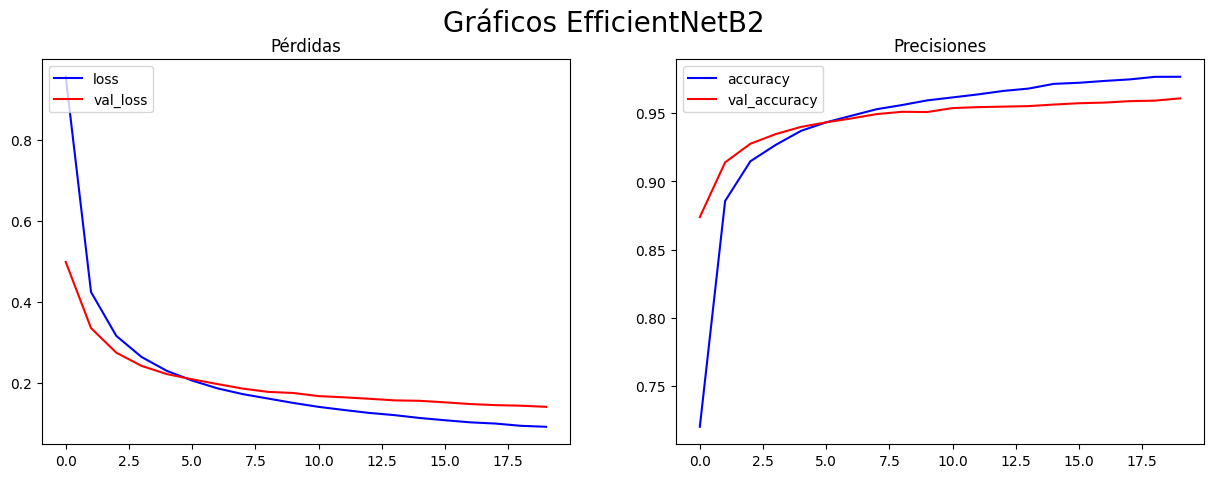

52/52 [==============================] - 10s 192ms/step - loss: 0.1298 - accuracy: 0.9636
***** Test loss:  0.12975797057151794
***** Test accuracy:  0.9636253118515015


In [7]:
fig = plt.figure(figsize=(15,5))

# Primera posición en figura de 1 fila y 2 columnas
fig.add_subplot(1,2,1)
plt.title(label='Pérdidas')
plt.plot(history.history['loss'], color='blue', label='loss')
plt.plot(history.history['val_loss'], color='red', label='val_loss')
plt.legend(loc="upper left")

# Segunda posición en figura de 1 fila y 2 columnas
fig.add_subplot(1,2,2)
plt.title(label='Precisiones')
plt.plot(history.history['accuracy'], color='blue', label='accuracy')
plt.plot(history.history['val_accuracy'], color='red', label='val_accuracy')
plt.legend(loc="upper left")

fig.suptitle('Gráficos EfficientNetB2', fontsize=20)
plt.show()
#---------------------------------
test_loss, test_acc = model.evaluate(testing_dataset, verbose=1)
print('***** Test loss: ', test_loss)
print('***** Test accuracy: ', test_acc)

# Guardar modelo

In [9]:
model_name = "CYBERRY_captcha_CNN_96.keras"
model.save(model_name)

# Predecir imágenes

In [11]:
import keras

model_name = "CYBERRY_captcha_CNN_96.keras"
model = keras.models.load_model(model_name)

In [10]:
def trocear_el_sushiV3(imagen: np.ndarray, num_trozos: int):
    lista_de_trocitos = []
    offset = int(NUM_COLUMNAS/num_trozos) # 200/6 = 33
    for trozo in range(num_trozos): 
        trozo_imagen = imagen[15:, trozo*offset:(trozo+1)*offset]
        trozo_imagen = Image.fromarray(trozo_imagen)
        trozo_imagen = trozo_imagen.resize(size=(IMG_SIZE,IMG_SIZE))
        trozo_imagen = np.array(trozo_imagen)
        lista_de_trocitos.append(trozo_imagen)
    return lista_de_trocitos

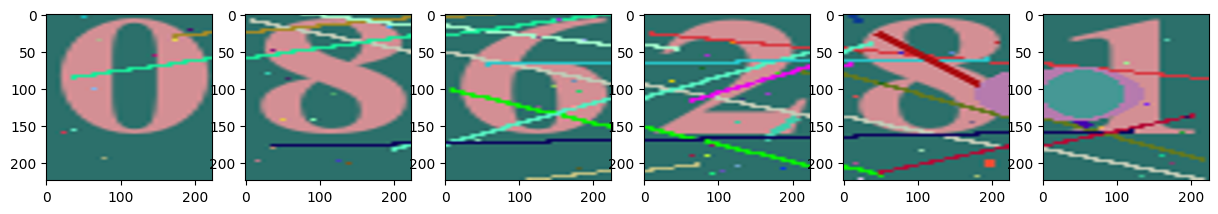

Predicted: 086281


In [23]:
# Una imagen pasada a mano
imagen = Image.open('validation/11366.png')
imagen = np.array(imagen)
cachos_prueba = trocear_el_sushiV3(imagen=imagen, num_trozos=NUM_TROZOS)

lista_aux = []
figura = plt.figure(figsize=(15,5))
i=1
for trozo in cachos_prueba:
    aux=trozo
    trozo = np.expand_dims(trozo, axis=0)
    label = np.argmax(model(trozo))
    lista_aux.append(str(label))
    figura.add_subplot(1,6,i)
    i+=1
    plt.imshow(aux)
plt.show()

valor = "".join(lista_aux)
print('Predicted:', valor) # str

# Matriz de confusión

In [29]:
predicted_labels = []
true_labels = []

datasetIterator = list(testing_dataset.as_numpy_iterator()) # 52 batches de 128

for imagenes, labels in datasetIterator: 
    true_labels += list(np.argmax(labels, axis=1)) 

    lote = imagenes/255
    predicciones = model.predict(imagenes)
    predicted_labels += list(np.argmax(predicciones, axis=1))   

3/3 [==============================] - 1s 190ms/step


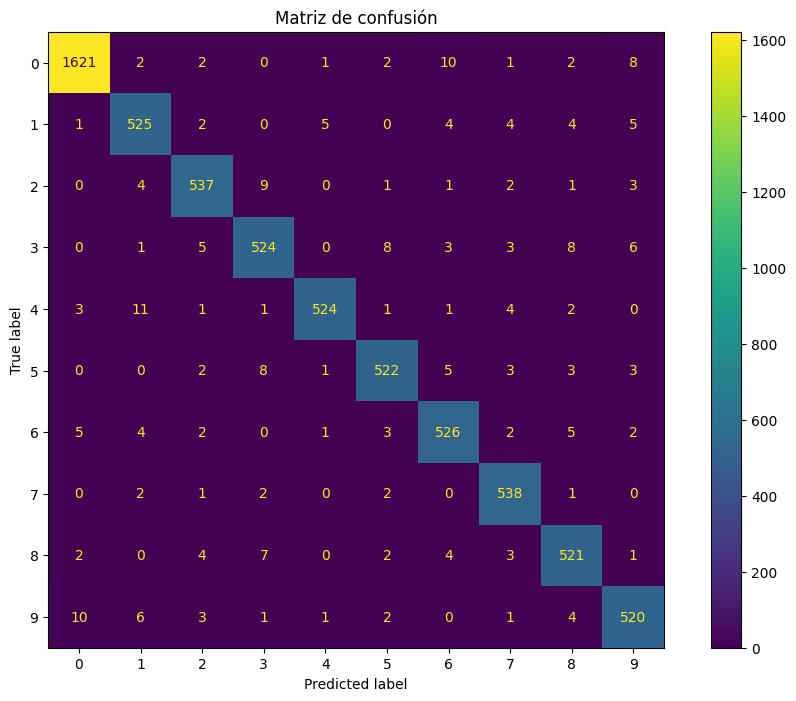

In [30]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

matrix = confusion_matrix(true_labels, predicted_labels)

figura, axes = plt.subplots(figsize=(12, 8))
confusionMatrix = ConfusionMatrixDisplay(matrix)  # display_labels=lista_razas_test
confusionMatrix.plot(ax=axes, cmap='viridis')
confusionMatrix.ax_.set_title("Matriz de confusión")

plt.show()